In [1]:
import numpy as np
import pylab as plt
from pydelay import dde23
import auxiliary_functions as aux
import seaborn as sns

%matplotlib inline
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})

In [2]:
params = {'tf' : 6000.0,  'dt' : 1.0                    # total time in min, step time
         ,'gm' : 24.0/np.log(2), 'gp' : 22.0/np.log(2)  # degradation rates HES RNA and protein, respectively
         ,'ga' : 50.0/np.log(2)                         # degradation rate target downstream gene
         ,'ti' : 1.9e+1                                 # intronic delay 
         ,'h0' : 1.0e+3, 'n'  : 5.0, 'nI' : 1.0         # Hill parameters for NICD activation of HES
         ,'k'  : 2.0e-1                                 # Homo and hetero dimer formation rate
         ,'m0' : 2.0e+2, 'p0' : 2.0                     # RNA and protein basic production rates
         ,'ma0': 2.0e+0, 'a0' : 0.1, 'na' : 2.0        # target gene production rate and Hill coeficient
         ,'e'  : 0.5e+0                                 # affinity rate between HES-ID and HES-HES on class-C sites
         ,'id' : 0.0e+0, 'I'  : 5.0e+2                  # amount of ID and NICD           
         } 
eqns   = {'m' : 'm0*Hp(I,h0,nI)*Hn(pp(t-ti),h0,n) - m/gm'  
         ,'p' : 'p0*m   - k*p*(p + id) - p/gp'
         ,'pp': 'k*p*p  - pp/gp'
         ,'pi': 'k*p*id - pi/gp'
         ,'ma': 'ma0*Hn(pp+e*pi,h0,na) - ma/ga'
         ,'a' : 'a0*ma - k*a*(a+id)  - a/ga'
         ,'aa': 'k*a*a - aa/ga'
         }
label = {'m' : 'HES mRNA (log2 values)',    'pp': 'HES-HES (log2 values)','pi': 'HES-ID (log2 values)',
         'ma': 'bHLH mRNA (log2 values)',   'a' : 'bHLH (log2 values)',   'aa': 'bHLH-bHLH (log2 values)', 
         'I' : 'Notch signal (log2 values)','id': 'ID (log2 values)'}

# ------ Setting initial condictions -------------
ic = {'m' : 0.0, 'p' : 0.0, 'pp': 0.0, 'pi': 0.0
     ,'ma': 0.0, 'a' : 0.0, 'aa': 0.0
     }
ic_dic = {'t': np.arange(0.0, params['ti']+params['dt'], params['dt'])}
for k in eqns.keys():
    ic_dic[k] = ic[k]*np.ones(len(ic_dic['t']))
# ------------------------------------------------
       
mycode = """
double Hn(double y, double y0, double n) {
    return 1.0/(1.0 + pow(y/y0, n));     }
double Hp(double y, double y0, double n) {
    return 1.0 - Hn(y, y0, n);           }
"""
dde = dde23(eqns=eqns, params=params, supportcode=mycode)
dde.hist_from_arrays(ic_dic)
dde.set_sim_params(tfinal=params['tf'], RelTol=1e-5, AbsTol=1e-5, dtmax=0.1, dtmin=1e-5, dt0=0.1, MaxIter=1e+8)
dde.run()

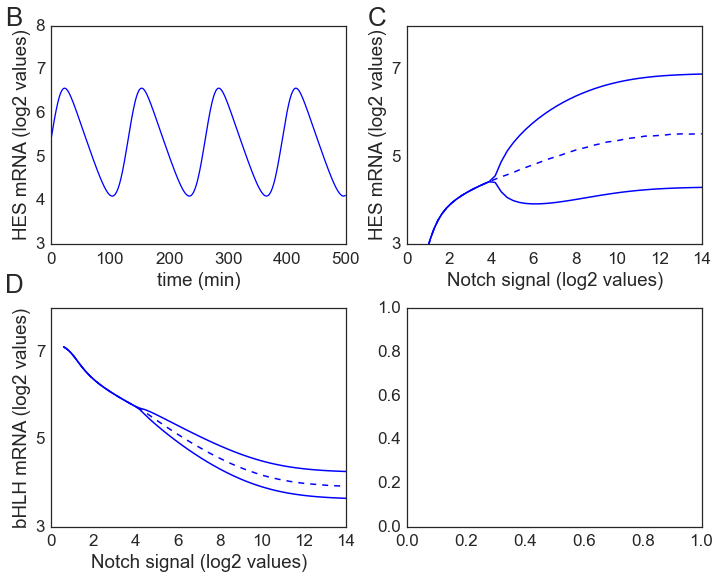

In [3]:
# ------------------- Figure 1B-D ----------------------------
trange=[params['tf']-500, params['tf']]
p_dic = {'I' : 2**np.arange(-1.0, 14.1, 0.3)}
s = aux.solve_eqs(dde, trange=trange, dtmax=params['dt'])

f = plt.subplots(2, 2, figsize=(5*2, 4*2), sharey=False)
ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax.text(-.15, 1.00, 'B', fontsize=26, transform=ax.transAxes)
ax.text(1.08, 1.00, 'C', fontsize=26, transform=ax.transAxes)
ax.text(-.15, -.22, 'D', fontsize=26, transform=ax.transAxes)
plt.plot(s['t'], s['m'], '-', c='b')
plt.ylabel(label['m'])
plt.xlabel('time (min)')
plt.ylim([3.0, 8.0])
plt.yticks(np.arange(3.0, 8.1, 1.0))
plt.xticks(np.arange(trange[0], trange[1]+1, 100), np.arange(0, 501, 100))

ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
aux.bifurcation(dde, 'I', p_dic['I'], 'm', trange, label=label, log2=True, yrange=[3.0, 8.0], ax=ax, xlim=[0,14])

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
aux.bifurcation(dde, 'I', p_dic['I'],'ma', trange, label=label, log2=True, yrange=[3.0, 8.0], ax=ax, xlim=[0,14])
plt.tight_layout()

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


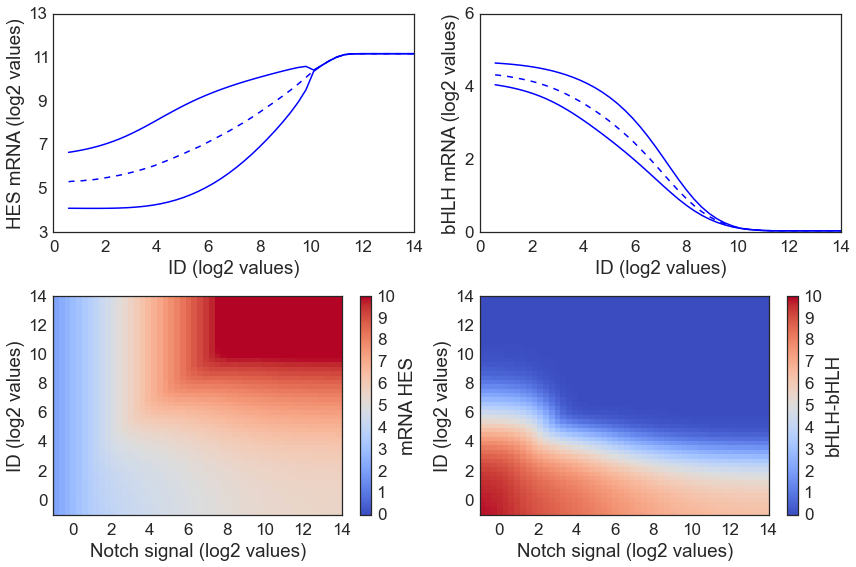

In [4]:
# ------------------- Figure 2B-E ----------------------------
cmap ='coolwarm'
p_dic['id'] = 2**np.arange( -1.0,  14.1, 0.3)

f = plt.subplots(2, 2, figsize=(6*2, 4*2), sharex=False)
ax.text(-.15, 0.96, 'E', fontsize=26, transform=ax.transAxes)
ax.text(1.28, 0.96, 'D', fontsize=26, transform=ax.transAxes)

ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
aux.bifurcation(dde, 'id', p_dic['id'], 'm', trange, label=label, yrange=[3.0, 13.0], ax=ax, xlim=[0,14])
ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
aux.bifurcation(dde, 'id', p_dic['id'], 'ma',trange, label=label, yrange=[0.0, 6.0],  ax=ax, xlim=[0,14])

m = aux.phase_diagram(dde, p_dic, axis=['I', 'id'], var=['m', 'pp', 'ma', 'aa'], trange=trange)
ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='mRNA HES')

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['aa'],p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='bHLH-bHLH')
plt.tight_layout()


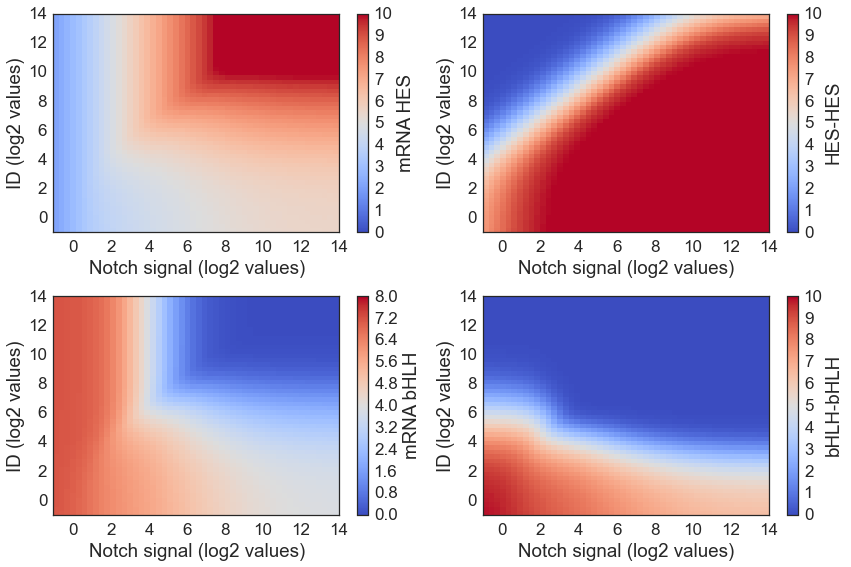

In [5]:
# ------------------- Supplementary figure ----------------------------
f = plt.subplots(2, 2, figsize=(6*2, 4*2), sharex=False, sharey=False)
ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='mRNA HES')

ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['pp'],p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='HES-HES')

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['ma'],p_dic, axis=['I', 'id'], label=label, clim=[0, 8], cmap=cmap, ax=ax, clabel='mRNA bHLH')

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
aux.plot_pdiagram(m['aa'],p_dic, axis=['I', 'id'], label=label, clim=[0,10], cmap=cmap, ax=ax, clabel='bHLH-bHLH')
plt.tight_layout()

## Notch activates both Hes and Id4

Notch activation of Id is considered by replacing the variable $id$ with $id * H^+(I)$. 

By doing that, the amount of IDs available is proportional to the amount of Notch signal

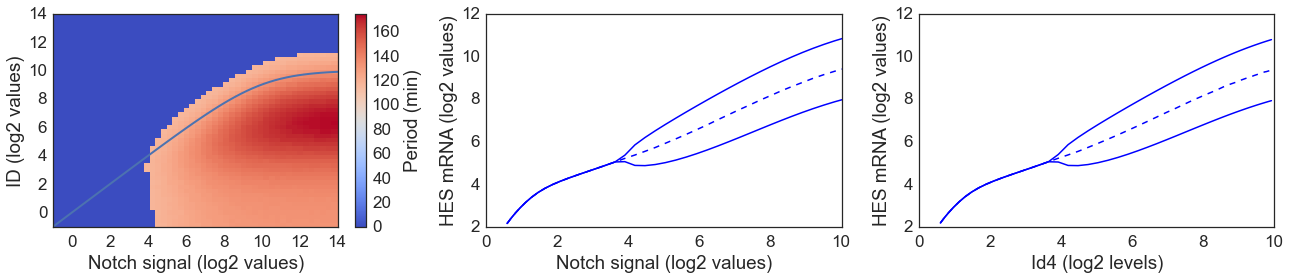

In [6]:
# ------------------- Figure 4B ----------------------------
params['id'] = 2**10
eqns   = {'m' : 'm0*Hp(I,h0,nI)*Hn(pp(t-ti),h0,n) - m/gm'  
         ,'p' : 'p0*m   - k*p*(p + id*Hp(I,h0,nI)) - p/gp'
         ,'pp': 'k*p*p  - pp/gp'
         ,'pi': 'k*p*id*Hp(I,h0,nI) - pi/gp'
          }
dde = dde23(eqns=eqns, params=params, supportcode=mycode)
dde.hist_from_arrays(ic_dic)
dde.set_sim_params(tfinal=params['tf'], RelTol=1e-3, AbsTol=1e-3, dtmax=0.1, dtmin=1e-3, dt0=0.1, MaxIter=1e+8)
dde.run()

f = plt.subplots(1, 3, figsize=(6*3, 4*1), sharex=False, sharey=False)
ax = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1)
aux.plot_pdiagram(m['m'], p_dic, axis=['I', 'id'], label=label, k='T', cmap=cmap, ax=ax, clabel='Period (min)')
plt.plot(np.log2(p_dic['I']), np.log2(params['id']/(1.0 + (params['h0']/p_dic['I']))), linewidth=2.0)

ax = plt.subplot2grid((1, 3), (0, 1), colspan=1, rowspan=1)
aux.bifurcation(dde, 'I', p_dic['I'], 'm', trange, label=label, yrange=[2,12], ax=ax, xlim=[0,10])

# ID levels are defined by params['id']*Hp(I,I0,nI)
ax = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)
aux.bifurcation(dde, 'I', params['id']/(1.0+params['h0']/p_dic['I']), 'm', trange, yrange=[2,12], ax=ax,  
                label={'I': 'Id4 (log2 levels)', 'm': 'HES mRNA (log2 values)'}, xlim=[0,10])
plt.tight_layout()